# Inspect and process OSRS dataset

In [1]:
import os
import sys
import collections
from collections import Counter
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cv2 as cv
import torch as t
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

## Load annotations from the raw txt files and get a subset of select name classes

#### 21 Classes
      0: Cow
      1: Cow_calf
      2: Dairy_cow
      3: Tree
      4: Evergreen_tree
      5: Oak_tree
      6: Willow_tree
      7: Yew_tree
      8: Plant
      9: Daisies
      10: Thistle
      11: Rocks
      12: Copper_rocks
      13: Tin_rocks
      14: Silver_rocks
      15: Iron_rocks
      16: Coal_rocks
      17: Gold_rocks
      18: Mithril_rocks
      19: Adamantite_rocks
      20: Clay_rocks

In [2]:
dataset = {}
root_dir = os.path.join('/home/chitraz/Documents/Projects/RealTimeODinOSRS', 'dataset/raw')

# what names to filter our dataset by
class_filter = ['Cow','Cow_calf', 'Dairy_cow'
    ,'Tree','Evergreen_tree','Oak_tree','Willow_tree','Yew_tree'
    ,'Plant','Daisies','Thistle'
    ,'Rocks','Copper_rocks','Tin_rocks','Silver_rocks','Iron_rocks','Coal_rocks', 'Gold_rocks', 'Mithril_rocks', 'Adamantite_rocks','Clay_rocks']

# open and read lines from annotation txt files
npc_f_in = open(os.path.join(root_dir, 'annotations/raw_NPCs.txt'), 'r')  
object_f_in = open(os.path.join(root_dir, 'annotations/raw_GameObjects.txt'), 'r')  
player_f_in = open(os.path.join(root_dir, 'annotations/raw_Players.txt'), 'r')  
item_f_in = open(os.path.join(root_dir, 'annotations/raw_GroundItems.txt'), 'r')  
npc_samples = npc_f_in.readlines()
object_samples = object_f_in.readlines()
player_samples = player_f_in.readlines()
item_samples = item_f_in.readlines()

name_count = {}
uid_count = {}

all_samples = npc_samples + object_samples + player_samples + item_samples

for sample in all_samples:
    # extract annotations
    fileName = sample.split(' ')[0]
    UID = sample.split(' ')[1]
    name = sample.split(' ')[2]
    x = int(sample.split(' ')[3])
    y = int(sample.split(' ')[4])
    width = int(sample.split(' ')[5])
    height = int(sample.split(' ')[6])
    num_poly = len(sample.split(' ')[7:])-1 # number of polygons for the seg mask
    seg_poly = []
    for i in range(num_poly):
        seg_poly.append(eval(sample.split(' ')[7:][i]))

    if name in class_filter: # filter
    
        # class count
        if name in name_count.keys():
            name_count[name] += 1
        else:
            name_count[name] = 1
        if UID in uid_count.keys():
            uid_count[UID] += 1
        else:
            uid_count[UID] = 1
        
        # store samples as a nested dict
        if fileName in dataset.keys():
            dataset[fileName]['UIDs'].append(UID)
            dataset[fileName]['Names'].append(name)
            dataset[fileName]['Boxes'].append((x, y, width, height))
            dataset[fileName]['Shapes'].append(seg_poly)
        else:
            dataset[fileName] = {}
            dataset[fileName]['UIDs'] = [UID]
            dataset[fileName]['Names'] = [name]
            dataset[fileName]['Boxes'] = [(x, y, width, height)]
            dataset[fileName]['Shapes'] = [seg_poly]
     


In [3]:
len(dataset) # number of images

11664

<BarContainer object of 21 artists>

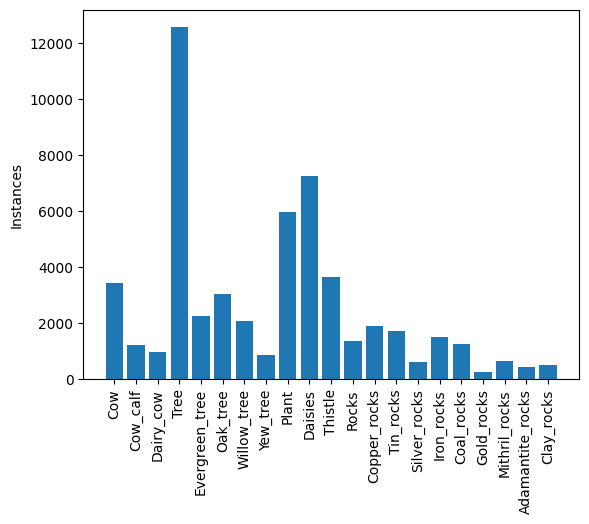

In [4]:
# plot class count
x = []
y = []
for cls in class_filter:
    x.append(cls)
    y.append(name_count[cls])
plt.xticks(rotation=90)
plt.ylabel('Instances')
plt.bar(x, y)

In [5]:
dict(sorted(name_count.items(), key=lambda item: item[1], reverse=True)) # print from largest to smallest counts

{'Tree': 12557,
 'Daisies': 7267,
 'Plant': 5982,
 'Thistle': 3650,
 'Cow': 3434,
 'Oak_tree': 3045,
 'Evergreen_tree': 2263,
 'Willow_tree': 2082,
 'Copper_rocks': 1897,
 'Tin_rocks': 1733,
 'Iron_rocks': 1512,
 'Rocks': 1381,
 'Coal_rocks': 1249,
 'Cow_calf': 1220,
 'Dairy_cow': 980,
 'Yew_tree': 858,
 'Mithril_rocks': 641,
 'Silver_rocks': 604,
 'Clay_rocks': 518,
 'Adamantite_rocks': 436,
 'Gold_rocks': 271}

In [6]:
len(name_count) # number of classes found 

21

In [7]:
len(class_filter) # number of classes in our subset

21

In [8]:
# make sure we have instances of each class
for cls in class_filter:
    if cls not in name_count.keys():
        print(cls + ' not found.')

## inspect a random sample: Bound boxes and segmentation masks 

In [9]:
# [x,y,width,height] -> [xmin,ymin,xmax,ymax], also clip the BBs to fit (540x340)
def RectToBB(bbox): 
    (x, y, width, height) = bbox
    x_min = np.max([x, 0])
    y_min = np.max([y, 0])
    x_max = np.min([x+width, 520])
    y_max = np.min([y+height, 340])
    return [x_min,y_min,x_max,y_max]

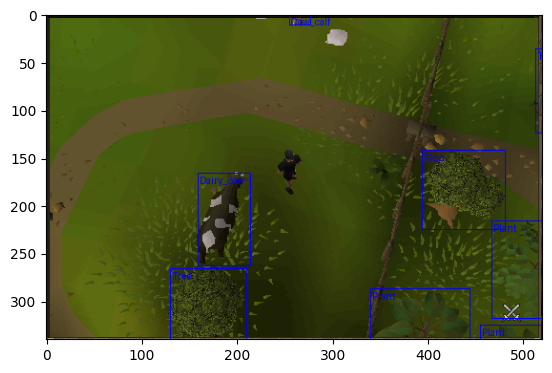

In [34]:
# index a random sample
img_index = np.random.randint(len(dataset)-1)
img_file = list(dataset)[img_index] 

# get sample info
img_path = os.path.join(root_dir, 'images/' + img_file)
bbox = dataset[img_file]['Boxes']
name_label = dataset[img_file]['Names']
uid_label = dataset[img_file]['UIDs']
seg_shape = dataset[img_file]['Shapes']

# get image on path
image = cv.imread(img_path)
image = image[:, :, [2, 1, 0]] 


# pre-processin
image = np.transpose(image,(2,0,1)) # (HxWxC) -> (CxHxW) 
image_tensor = t.from_numpy(image)

boxes = t.tensor([RectToBB(box) for box in bbox],dtype=t.float)
bb_draw_result = draw_bounding_boxes(image_tensor, boxes, name_label, colors='blue')

# convert to plotable image
annot_img = bb_draw_result.numpy()
annot_img = np.transpose(annot_img,(1,2,0)) # (CxHxW) -> (HxWxC)

plt.imshow(annot_img)

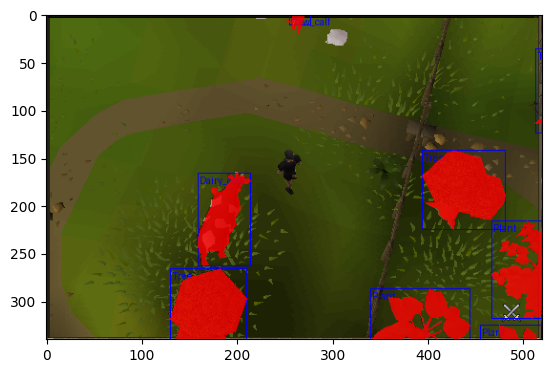

In [35]:
# get segmentations mask from the object shapes
width = 520
height = 340
masks = []
for shapes in seg_shape:
    img = Image.new('L', (width, height), 0)
    for shape in shapes:
        polygon = [(round(x),round(y)) for (x,y) in shape] # round to nearest pixel coridinate

        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
    masks.append(t.from_numpy(np.array(img, dtype=bool))) # save masks for each objects


# draw seg masks on top of bounding box drawn image tensor
combined_mask = masks[0]
for mask in masks[1:]:
    combined_mask += mask
seg_draw_result = draw_segmentation_masks(bb_draw_result, combined_mask, colors= 'red')


# convert to plotable image
annot_img = seg_draw_result.numpy()
annot_img = np.transpose(annot_img,(1,2,0)) # (CxHxW) -> (HxWxC)

plt.imshow(annot_img)

## train(80%)/valid(20%) split 

In [12]:
# set random seed for repeatability
np.random.seed(0)

# train/valid ratio
split_ratio = 0.8

# list of tuples (fileName, class labels, BBs)
train_set = []
valid_set = []

for img_fileName in dataset.keys():
    boxes = dataset[img_fileName]['Boxes']
    cls_idxs = []
    for name in dataset[img_fileName]['Names']:
        cls_idx = class_filter.index(name)
        cls_idxs.append(cls_idx)

    if np.random.rand() < split_ratio: 
        train_set.append((img_fileName, cls_idxs, boxes))
    else:
        valid_set.append((img_fileName, cls_idxs, boxes))


# split by images not instances, dont want images to be shared by both training and validation samples!

In [13]:
len(train_set)

9368

In [14]:
len(valid_set)

2296

In [15]:
# do a class count of both train and val sets
train_cls_count = {}
valid_cls_count = {}

for _,cls_idxs,_ in train_set:
    for cls_idx in cls_idxs:
        cls_name = class_filter[cls_idx]
        if  cls_name in train_cls_count.keys():
            train_cls_count[cls_name] += 1
        else:
            train_cls_count[cls_name] = 1

for _,cls_idxs,_ in valid_set:
    for cls_idx in cls_idxs:
        cls_name = class_filter[cls_idx]
        if  cls_name in valid_cls_count.keys():
            valid_cls_count[cls_name] += 1
        else:
            valid_cls_count[cls_name] = 1

<BarContainer object of 21 artists>

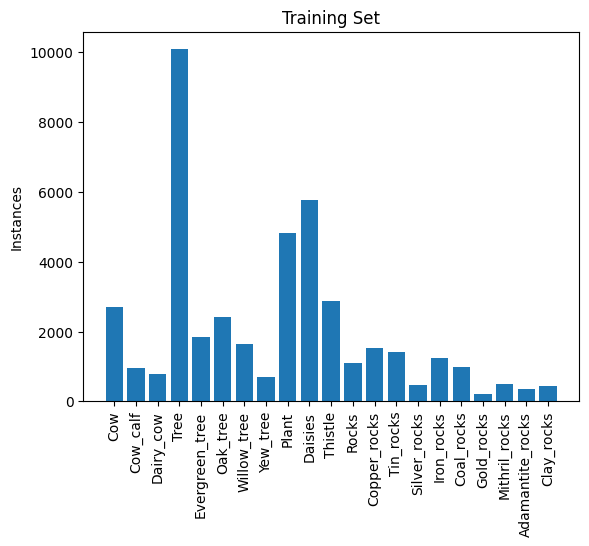

In [16]:
# plot instance count in training set
x = []
y = []
for cls in class_filter:
    x.append(cls)
    y.append(train_cls_count[cls])
plt.xticks(rotation=90)
plt.ylabel('Instances')
plt.title('Training Set')
plt.bar(x, y)

<BarContainer object of 21 artists>

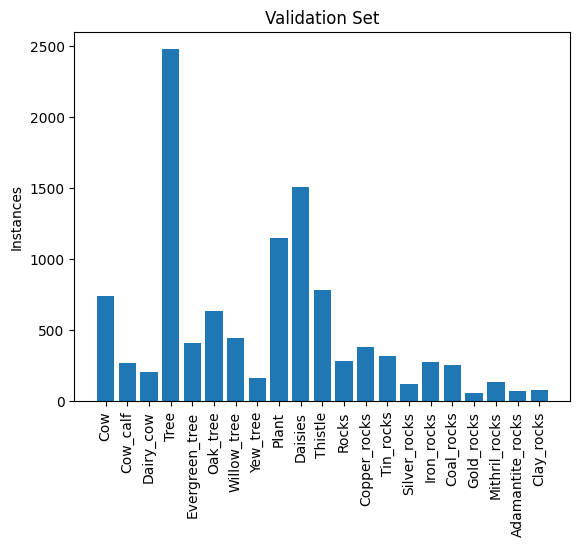

In [17]:
# plot instance count in validation set
x = []
y = []
for cls in class_filter:
    x.append(cls)
    y.append(valid_cls_count[cls])
plt.xticks(rotation=90)
plt.ylabel('Instances')
plt.title('Validation Set')
plt.bar(x, y)

## save in format required for YOLO11 training
#### Folders: train/images - train/labels - val/images - val/labels 
#### Note: Distributed Focal Loss (dfl_loss) used in yolo11 training which already addresses class imblance so no need to upsample train set

In [18]:
for sample in train_set:
    img_fileName, cls_idxs, boxes = sample # unpack

    # load image and save into train/images
    img_path = os.path.join(root_dir, 'images/' + img_fileName)
    new_img_path = os.path.join(root_dir.replace("raw", "train"), 'images/' + img_fileName)
    image = cv.imread(img_path)
    cv.imwrite(new_img_path,image)

    # save annotation as txt file into train/labels, 1 txt file per image
    txt_fileName = img_fileName.replace('.png', '.txt')
    annot_file = open(os.path.join(root_dir.replace("raw", "train"), 'labels/' + txt_fileName), "w") 
    for cls_idx, box in zip(cls_idxs, boxes):
        
        # format box to (center_x, center_y, width, height) and also normalize and round to 6 decimals
        x_min, y_min, x_max, y_max = RectToBB(box)

        if ((x_min > x_max) or (y_min > y_max)):
            print('1 bad bounding box found for ' + class_filter[cls_idx] + ' in ' + img_fileName)
            # don't save instances with invalid BB
        else:
            center_x = round((x_min + (x_max-x_min)/2)/520, 6)
            center_y = round((y_min + (y_max-y_min)/2)/340, 6)
            width = round((x_max - x_min)/520, 6)
            height = round((y_max - y_min)/340, 6)
            # save in txt file
            annot_file.write(str(cls_idx) + ' ' + str(center_x) + ' ' + str(center_y) + ' '
                             + str(width) + ' ' + str(height) +'\n')
print('done')


1 bad bounding box found for Cow in 3177_3323_0_527_260_1877.png
1 bad bounding box found for Cow in 3202_3298_0_556_368_1593.png
1 bad bounding box found for Cow in 3205_3289_0_1401_154_505.png
1 bad bounding box found for Cow in 3202_3290_0_964_206_669.png
1 bad bounding box found for Cow in 3197_3285_0_653_161_676.png
1 bad bounding box found for Cow in 3205_3289_0_956_333_588.png
1 bad bounding box found for Cow_calf in 3251_3289_0_610_194_765.png
1 bad bounding box found for Cow in 3197_3283_0_1089_183_1814.png
1 bad bounding box found for Cow in 3197_3285_0_1066_247_596.png
1 bad bounding box found for Cow in 3210_3291_0_954_224_1814.png
1 bad bounding box found for Cow in 3202_3296_0_1317_170_1287.png
1 bad bounding box found for Cow in 3191_3318_0_603_225_487.png
1 bad bounding box found for Cow_calf in 3169_3327_0_602_335_923.png
1 bad bounding box found for Cow in 3169_3319_0_473_260_1879.png
1 bad bounding box found for Cow in 3169_3319_0_473_260_1879.png
1 bad bounding box 

In [19]:
# do same for val
for sample in valid_set:
    img_fileName, cls_idxs, boxes = sample # unpack

    # load image and save into val/images
    img_path = os.path.join(root_dir, 'images/' + img_fileName)
    new_img_path = os.path.join(root_dir.replace("raw", "val"), 'images/' + img_fileName)
    image = cv.imread(img_path)
    cv.imwrite(new_img_path,image)

    # save annotation as txt file into val/labels, 1 txt file per image
    txt_fileName = img_fileName.replace('.png', '.txt')
    annot_file = open(os.path.join(root_dir.replace("raw", "val"), 'labels/' + txt_fileName), "w") 
    for cls_idx, box in zip(cls_idxs, boxes):
        # format box to (center_x, center_y, width, height) and also normalize and round to 6 decimals
        x_min, y_min, x_max, y_max = RectToBB(box)
        
        if ((x_min > x_max) or (y_min > y_max)):
            print('1 bad bounding box found for ' + class_filter[cls_idx] + ' in ' + img_fileName)
            # don't save instances with invalid BB
        else:
            center_x = round((x_min + (x_max-x_min)/2)/520, 6)
            center_y = round((y_min + (y_max-y_min)/2)/340, 6)
            width = round((x_max - x_min)/520, 6)
            height = round((y_max - y_min)/340, 6)
            # save in txt file
            annot_file.write(str(cls_idx) + ' ' + str(center_x) + ' ' + str(center_y) + ' '
                             + str(width) + ' ' + str(height) +'\n')
print('done')

1 bad bounding box found for Cow in 3205_3297_0_1231_383_1537.png
1 bad bounding box found for Cow in 3202_3296_0_809_259_1486.png
1 bad bounding box found for Cow in 3203_3289_0_1012_160_197.png
1 bad bounding box found for Cow in 3197_3283_0_697_172_622.png
1 bad bounding box found for Cow_calf in 3191_3282_0_716_211_1741.png
1 bad bounding box found for Cow_calf in 3251_3282_0_473_335_393.png
1 bad bounding box found for Evergreen_tree in 3020_3457_0_1101_148_1890.png
done
